# Region Merging Segmentation

### Problem Statement.

Region merging is an effective scheme for region growing based segmentation. Region growing may begin with each pixel within an image in which a pixel represents a single region initially. In this problem we shall use the __Boundary Melting__ approach for merging regions, and effectively segment the given image of 'Mixed Vegetables'.

The fundamental part of this task, is to create a __Supergrid Edge Data Structure__. This matrix stores the crack edges between adjacent regions.

I shall state the strategy we will be using for tackling the problem below, and we shall follow the procedure step by step in following sections.

1. We begin by clustering/assigning a region to each pixel in the image based on the pixel intensity. If the pixel intensities of two adjacent pixels differ by less than a threshold, then we assign the same region label to it.

2. Next we calculate the average pixel intensity for each region that we obtained from step 1.

3. Now we initialise the supergrid data structure, which is twice the size of original image, and store the average intensities per pixel calculated above, for each pixel representation in the supergrid.

4. Next, we calculate the difference between the pixel intensities of adjacent regions, and store it as a crack edge in the pixels between the regions.

5. We remove the weak crack edges if the difference is below a threshold, and replace this edge by average value of neighbouring pixels. If we have a strong edge, we replace this pixel by 0.

6. We then calculate the perimeter of each region, and also the lengths of the common boundaries shared by every adjacent regions.

7. We eliminate the common boundaries between two regions if the following criteria is not satisfied:
            W/min(l1,l2) ≥ Threshold, where l1 and l2 are the perimeters of adjacent regions.
            
8. When we recursively remove all the weak edges, until we have no more edges to remove as per the criterion, we terminate the process.

9. No we have the segmented regions and corresponding edges, which we shall super impose over the original image, to get the region segmentation.

Let us begin, by importing all the necessary python packages.

In [1]:
% matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import scipy.ndimage as ndi
import math

Let us define a helper function to plot our images/graphs. We shall be using this function quite often, for analysing our output, hence we define this function before we begin our solution.

In [2]:
def plot_input(img, title):
    plt.imshow(img, cmap = 'gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

Next, let us view the given test image in grayscale. For that we shall read the image using OpenCV defined reader, and plot the image using our helper function.

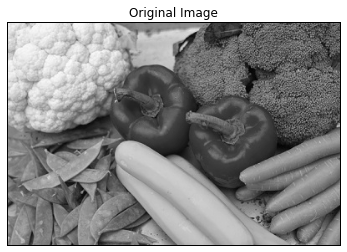

In [3]:
original_img = cv2.imread('./MixedVegetables.jpg', 0)
plot_input(original_img, 'Original Image')

It is often beneficial to pre-process our given raw image. 

In our preprocessing step, we shall smooth the given image using a Gaussian filter, to remove any noise in the image. As our crack-edge detection and region merging is highly dependent on the difference and uniformity of pixel intensities respectively, we would like to remove extremely high frequencies in the image.

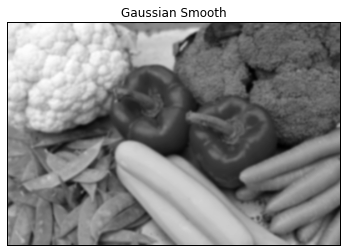

In [4]:
gaussian_smooth_img = ndi.filters.gaussian_filter(original_img, 1.2)
plot_input(gaussian_smooth_img, 'Gaussian Smooth')

Let us now begin with our solution, for implementing the __region merging via boundary melting__ algorithm. 

The most fundamental part of the solution is in appropriate creation of __Supergrid data structure, which holds the crack edges.__

Below, we have stored the original image dimensions in variables __M__ and __N__. 

Next we have defined a matrix 'adj_values' to store the intensities of 4 neighbors corresponding to each pixel.

'region_label' is a matrix that stores the labels of the regions to which each pixel belong. We have initialised the matrices to 0.

'avg_intensity_reg' is a matrix that stores the pixel intensity values(min,max,avg) for every region. Initially, each pixel is considered to be its own region, hence we have values corresponding to each pixel, but as the merging begins, each value in this matrix denotes the values corresponding to the region the pixel belongs.

In [5]:
[M,N] = original_img.shape
adj_values = np.array([ {'left': 0, 'right':0,'top':0,'down':0} for x in range(M * N + 1)])
region_label = np.array([[ 0 for x in range(N)] for y in range(M)])

avg_intensity_reg = []
for i in range(M * N +1):
    avg_intensity_reg.append({'min':0,'max':0,'avg':0})

Next, we shall initialise the __Supergrid data structure__, which is represented by a matrix of size twice that of the original image. 

We call this matrix, __crack_edge_data__. We begin by storing the crack edges between two regions (pixel intensity differences), and recursively eliminate weak edges in the supergrid, between two regions as we merge them.

In [6]:
crack_edge_data = np.zeros((2*M-1,2*N-1))
label_data = np.zeros((2*M-1,2*N-1))

Next, we shall recursively iterate over each pixel and check if the label is not already set for the given pixel. If not set, we give the pixel a label and proceed to its neighbour.

__Note: If a label is not set ie. it is 0, but the pixel satisfies homogenity criteria, corresponding to its neighbours, we set the label of the neighbours to this pixel.__

For choosing the threshold, I iteratively generated the segmentation result for T1 in [1,2,3,4,5,6,7,8,9,10]. 

From the experimented results, we opined that, high values of T1(in this context) tend to be more lenient in terms of merging, and average out a lot of regions as 1.

<img src="experiments/3.jpg" width="350"><center> Output for T1 = 3</center>

<img src="experiments/6.jpg" width="350"><center> Output for T1 = 6</center>

<img src="experiments/9.jpg" width="350"><center> Output for T1 = 9</center>

Lower values are more stringent, and as such create a lot of regions, which also comprise of noise. Hence, we had to choose the best threshold available for our use case.

Looking at the images above, T1=9 seems a good threshold for initial filtering, but its crack edge representation shall prove, why we have not chosen such a large threshold.

<center><img src="experiments/crack_edge_t1_9.png" width="500"> Super grid representation for T1=9</center>

<center><img src="experiments/crack_edge_t1_3.png" width="400"> Super grid representation for T1=3</center>

<center><img src="experiments/crack_edge_t1_5.png" width="500"> Super grid representation for T1=5</center>

__After examining the crack edge data and the region segmentation results for different thresholds, we decided to choose T1 = 5.__

After execution of the below code snippet, each pixel should have a label, and must belong to a region based on the average intensity of a region.

In [8]:
def split_label_recursively(i,j,label,pixel):
    T1 = 5 # Tested for all values from 1 to 10, the higher the values the more lenient the merging, lower values create more regions and have high noise. 
    if (i < 0 or i >= M or j < 0 or j >= N) or region_label[i,j] != 0 or original_img[i,j] < pixel - T1 or original_img[i,j] > pixel + T1:
        return

    pixel = original_img[i,j]

    if avg_intensity_reg[label]['min'] > pixel:
        avg_intensity_reg[label]['min'] = pixel
    elif avg_intensity_reg[label]['max'] < pixel:
        avg_intensity_reg[label]['max'] = pixel

    region_label[i,j] = label
    if adj_values[label]['left'] > i:
        adj_values[label]['left'] = i 
    elif adj_values[label]['right'] < i: 
        adj_values[label]['right'] = i 
    if adj_values[label]['top'] > j:
        adj_values[label]['top'] = j 
    elif adj_values[label]['down'] < j: 
        adj_values[label]['down'] = j
    split_label_recursively(i-1,j+1,label,pixel)
    split_label_recursively(i,j+1,label,pixel)
    split_label_recursively(i+1,j+1,label,pixel)
    split_label_recursively(i+1,j,label,pixel)
    split_label_recursively(i+1,j-1,label,pixel)

In [9]:
label = 0
for i in range(M):
    for j in range(N):
        if region_label[i,j] == 0:
            label = label + 1
            pixel = original_img[i,j]
            adj_values[label]['left'] = i
            adj_values[label]['right'] = i
            adj_values[label]['top'] = j
            adj_values[label]['down'] = j
            split_label_recursively(i,j,label,pixel)
fin_label = label

Thus we have made a first pass through the image pixels, and split the image into different simple regions, based on the homogenous intensity criteria for a given region. 

Next let us calculate the average pixel intensity for each region, which shall be stored across every pixel in a region.

In [10]:
for i in range(len(avg_intensity_reg)):
    avg_intensity_reg[i]['avg'] = (avg_intensity_reg[i]['max'] + avg_intensity_reg[i]['min'])/2

Next, we shall initialise the __Supergrid data__ to hold the average intensities uniformly as per the region labels defined above.

We shall also keep track of the region labels in the __Supergrid Data structure__ using the matrix __label_data__. 

In [11]:
for i in range(M):
    for j in range(N):
        crack_edge_data[2*i,2*j] = avg_intensity_reg[region_label[i,j]]['avg']
        label_data[2*i,2*j] = region_label[i,j]

As we have studied for the Supergrid data structure, we have to store the differences between the pixel intensities of neighbouring pixels in the middle pixel. These are called as the __CRACK EDGES__. 

The strength of these crack edges, help us determine if we should merge two regions or not.

In the following section, we shall compute the crack edges and store them as stated above.

First we shall iterate all the columns and store the corresponding crack edges, and then move vertically through the pixels for storing the crack edges. Next, we check how many neighbours have a crack edge and if current pixel is a crossing point of edges, by checking the adjacent pixels. 

In [12]:
def check_neighbours_crack_edge(i,j):
    pix_val = 0
    pixel_label = 0
    count = 0
    if i-1 >= 0:
        if crack_edge_data[i-1,j] != 0:
            pix_val = crack_edge_data[i-1,j]
            pixel_label = label_data[i-1,j]
        else:
            count = count + 1
    if j-1 >= 0:
        if crack_edge_data[i,j-1] != 0:
            pix_val = crack_edge_data[i,j-1]
            pixel_label = label_data[i,j-1]
        else:
            count = count + 1
    if i+1 < len(crack_edge_data):
        if crack_edge_data[i+1,j] != 0:
            pix_val = crack_edge_data[i+1,j]
            pixel_label = label_data[i+1,j]
        else:
            count = count + 1
    if j+1 < len(crack_edge_data[0]):
        if crack_edge_data[i,j+1] != 0:
            pix_val = crack_edge_data[i,j+1]
            pixel_label = label_data[i,j+1]
        else:
            count = count + 1
    if count >2:
        return 0,0
    else:
        return pix_val,pixel_label

In [13]:
for i in range(M):
    for j in range(N):
        if 2*j < len(crack_edge_data[0]) and 2*i+2 < len(crack_edge_data):
            diff = crack_edge_data[2*i,2*j] - crack_edge_data[2*i+2,2*j]
            if diff != 0:
                crack_edge_data[2*i+1,2*j] = 0
                label_data[2*i+1,2*j] = 0
            else:
                crack_edge_data[2*i+1,2*j] = crack_edge_data[2*i,2*j]
                label_data[2*i+1,2*j] = label_data[2*i,2*j]
        if 2*j+2 < len(crack_edge_data[0]) and 2*i < len(crack_edge_data):
            diff = crack_edge_data[2*i,2*j] - crack_edge_data[2*i,2*j+2]
            if diff != 0:
                crack_edge_data[2*i,2*j+1] = 0
                label_data[2*i,2*j+1] = 0
            else:
                crack_edge_data[2*i,2*j+1] = crack_edge_data[2*i,2*j]
                label_data[2*i,2*j+1] = label_data[2*i,2*j]
        if 2*i+1 < len(crack_edge_data) and 2*j+1 < len(crack_edge_data[0]):
            crack_edge_data[2*i+1,2*j+1],label_data[2*i+1,2*j+1] = check_neighbours_crack_edge(2*i+1,2*j+1)

In the section below, we have defined two helper functions. 
    1. 'adjacent_reg' - The first one returns the labels assigned to the two adjacent regions which enclose a crack-edge pixel.
    2. 'update_perimeters' - The second one computes the updated perimeters of the obtained regions. If two regions share a common boundary, this function also updates the length of shared boundary between two regions, along with the perimeters of individual regions.
    
These functions are useful in the merge process, after we have removed the weak edges, which we shall do in the following section. The perimeters calculated by these function are used to check the condition while merging two regions.

In [14]:
def adjacent_reg(i,j):
    lab1 = 0
    lab2 = 0
    test_labels = [0,0,0,0]
    if i-1 >= 0:
        if crack_edge_data[i-1,j] != 0 :
            test_labels[0] = label_data[i-1,j]
    if j-1 >= 0:
        if crack_edge_data[i,j-1] != 0 :
            test_labels[1] = label_data[i,j-1]
    if i+1 < len(crack_edge_data):
        if crack_edge_data[i+1,j] != 0 :
            test_labels[2] = label_data[i+1,j]
    if j+1 < len(crack_edge_data[0]):
        if crack_edge_data[i,j+1] != 0 :
            test_labels[3] = label_data[i,j+1]
    lab1 = test_labels[0]
    if lab1 == 0:
        lab1 = test_labels[1]
    else:
        lab2 = test_labels[1]
    if lab1 == 0:
        lab1 = test_labels[2]
    else:
        lab2 = test_labels[2]
    if lab1 == 0:
        lab1 = test_labels[3]
    else:
        lab2 = test_labels[3]
    return lab1,lab2

def update_perimeters():
    common_perimeter = np.array([[ 0 for i in range(fin_label+1)] for j in range(fin_label+1)])
    region_perimeter = np.array([ 0 for i in range(fin_label+1)]) 

    for i in range(len(crack_edge_data)):
        for j in range(len(crack_edge_data[0])):
            R1 = 0
            R2 = 0
            if crack_edge_data[i,j] == 0:
                [R1,R2] = adjacent_reg(i,j)
                if R1 != 0:
                    region_perimeter[int(R1)] = region_perimeter[int(R1)] + 1
                if R2 != 0:
                    region_perimeter[int(R2)] = region_perimeter[int(R2)] + 1
                    if R1 != 0:
                        common_perimeter[int(R1),int(R2)] = common_perimeter[int(R1),int(R2)] + 1
                        common_perimeter[int(R2),int(R1)] = common_perimeter[int(R2),int(R1)] + 1
    return common_perimeter, region_perimeter

Now that we have the crack edge data structure well defined, and our helper functions to identify regions, calculate their perimeters and length of common boundary are in place, let us define the function to merge two given regions.

The merge function is called after we have decided to eliminate an edge between two regions. The function replaces the region with lower average pixel intensity values with the one having higher average of the two.

The function implementation is shown below:

In [15]:
def merge_reg(R1, R2):
    reg = 0
    if avg_intensity_reg[int(R1)]['avg'] < avg_intensity_reg[int(R2)]['avg']:
        reg = avg_intensity_reg[int(R1)]['avg']
        replaceByReg = avg_intensity_reg[int(R2)]['avg']
        R = R2
    else:
        reg = avg_intensity_reg[int(R2)]['avg']
        replaceByReg = avg_intensity_reg[int(R1)]['avg']
        R = R1

    for i in range(2* adj_values[int(reg)]['left'],2*adj_values[int(reg)]['right']):
        for j in range(2*adj_values[int(reg)]['top'],2*adj_values[int(reg)]['down']):
            if crack_edge_data[i,j] == reg:
                crack_edge_data[i,j] = replaceByReg
                label_data[i,j] = R
            if crack_edge_data[i,j] == 0:
                [R3,R4] = adjacent_reg(i,j)
                if (R3 == R1 and R4 == R2) or (R3 == R2 and R4 == R1):
                    crack_edge_data[i,j] = replaceByReg
                    label_data[i,j] = R

We have defined the function for merging two regions, but when do we decide if we have to merge two adjacent regions?

Common boundaries of adjacent regions R1 and R2 are removed if:
                
                W/min(l1,l2) ≥ threshold
                
where, W is the the number of weak edges in common boundary and l1, l2 are the perimeters of R1 and R2 respectively.

We use this criteria for removing weak edges between two adjacent regions, and the threshold needs to be fixed by tuning.

In the function below, we have implemented a function to eliminate weak edges from adjacent regions R1 and R2, if the above criterion is satisfied.

In [16]:
def elim_weak_edges(common_perimeter, region_perimeter):
    edge_rem_threshold = 0.8
    for i in range(len(crack_edge_data)):
        for j in range(len(crack_edge_data[0])):
            R1 = 0
            R2 = 0
            if crack_edge_data[i,j] == 0:
                [R1,R2] = adjacent_reg(i,j)
                if R1 != 0 and R2 != 0:
                    W = common_perimeter[int(R1),int(R2)]
                    L1 = region_perimeter[int(R1)]
                    L2 = region_perimeter[int(R2)]
                    if L1 <= L2:
                        min_perimeter = L1
                    else:
                        min_perimeter = L2
                    score = W/min_perimeter
                    if score >= edge_rem_threshold:
                        merge_reg(R1,R2)

The threshold above can be set by tuning for particular value which helps us obtain ideal segmentation. I experimented over various values of threshold between 0.1 to 0.9, and set this threshold by observation.

Next we overlay the obtained region edges over the original image, to view the various segmented regions in the original image provided.

In [17]:
def superimpose_edges():
    for i in range(len(crack_edge_data)):
        for j in range(len(crack_edge_data[0])):
            if crack_edge_data[i,j] == 0:
                original_img[int((i+1)/2),int((j+1)/2)] = 255

In [18]:
common_perimeter, region_perimeter = update_perimeters()
elim_weak_edges(common_perimeter, region_perimeter)

In [19]:
superimpose_edges()

## Results

In the following section, we shall visualise our results. We start by plotting our supergrid data structure, which holds the crack edges.

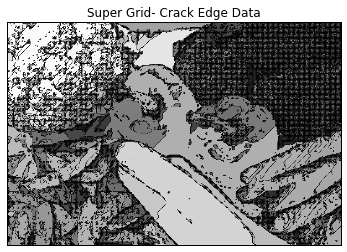

In [20]:
plot_input(crack_edge_data, 'Super Grid- Crack Edge Data')

Below, we can see the segmented regions in the image. Regions have pixels with same average intensity value. 

The colored plot of the segmentation, provides a much understandable visualisation, as shown below.

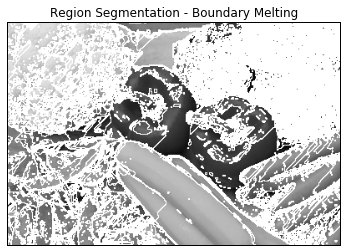

In [21]:
plot_input(original_img, 'Region Segmentation - Boundary Melting')

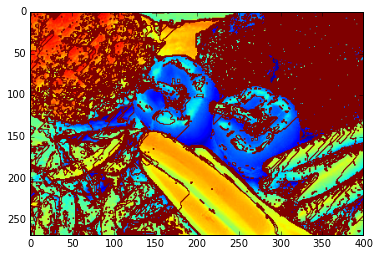

In [22]:
plt.imshow(original_img)
plt.show()

## Conclusion

As can be seen in the result image above, we have been __successful in implementing region segmentation using region merging via boundary melting__. We can distinctly visualise the different vegetables in the above image, with each having their own color. Peppers are represented in blue, the bananas are in yellow, bean pods and carrots have similar gray scale intensities, and hence they have similar color, while the broccoli and the cauliflower(in top right and left respectively) have been segmented in their own color.

#### Note: The code presented in the sections above is useful for implement-as-you-go strategy or for study purpose. I had written the code as I proceeded in tackling each subtask, and as a result is not optimal and hence is computationally expensive. A well compiled code in object oriented programming structure has been attached along with this report.